In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_california_housing

df = pd.read_csv("diabetes (3).csv")
df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:

X = df.drop('Outcome',axis=1)
y = df['Outcome']

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train a Random Forest Regressor
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)



RandomForestRegressor(random_state=42)

[]

<Figure size 3000x3000 with 0 Axes>

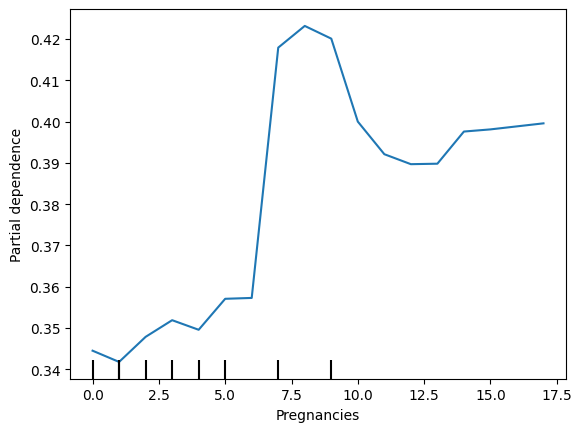

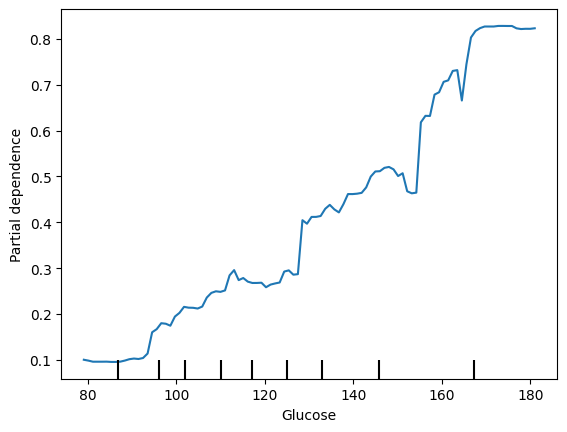

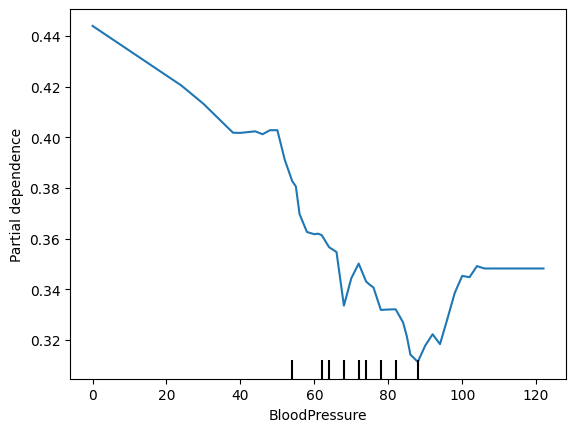

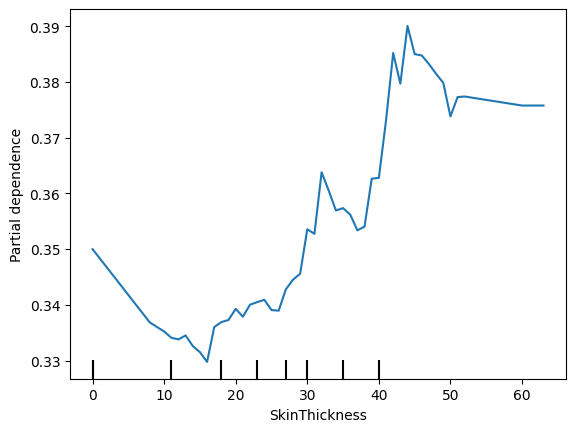

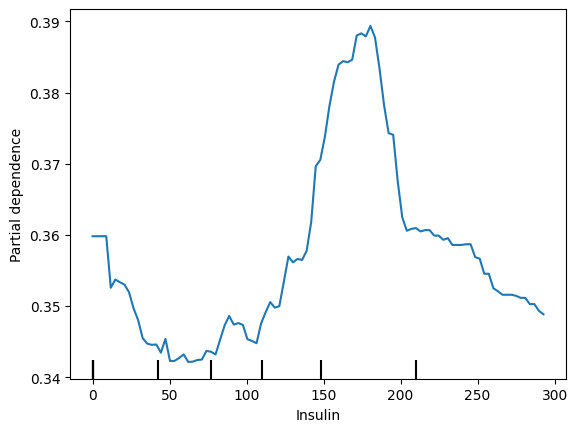

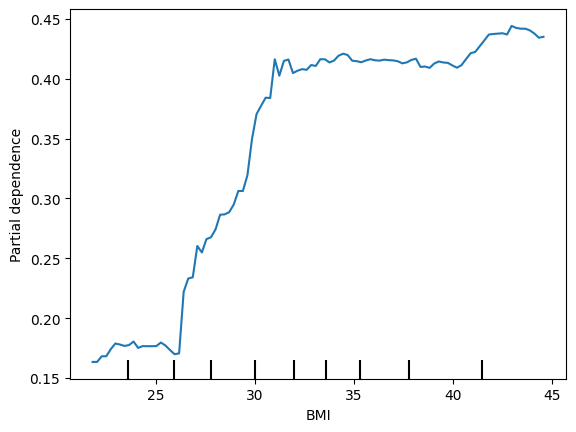

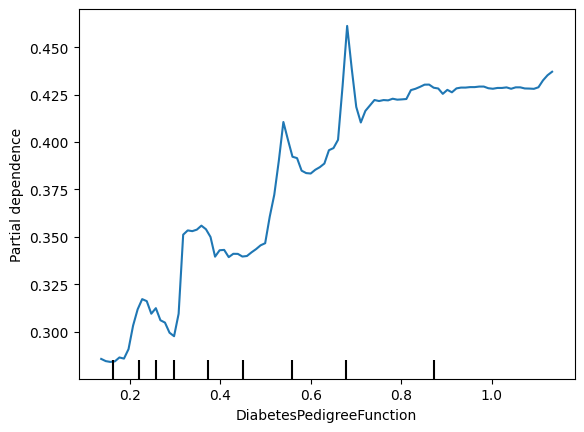

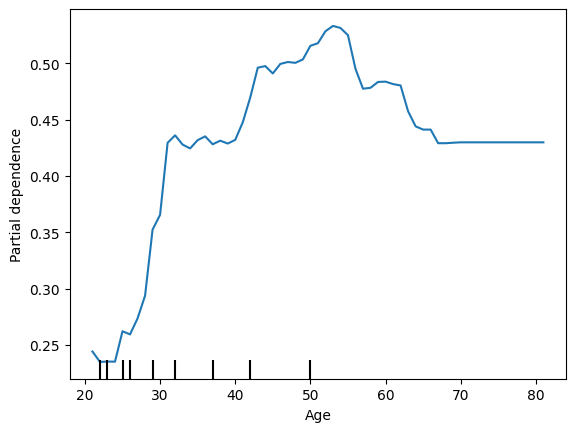

In [6]:
plt.figure(figsize=(30,30))
for col in X_train.columns:
  PartialDependenceDisplay.from_estimator(model,X_train,[col])
plt.plot()

[]

<Figure size 3000x3000 with 0 Axes>

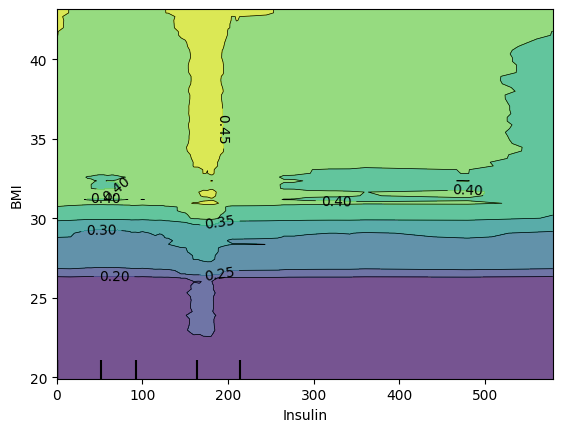

In [269]:
plt.figure(figsize=(30,30))
PartialDependenceDisplay.from_estimator(model,X_test,[('Insulin','BMI')])
plt.plot()

Grad CAM

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Import tf-keras-vis (make sure it's installed via pip install tf-keras-vis)
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

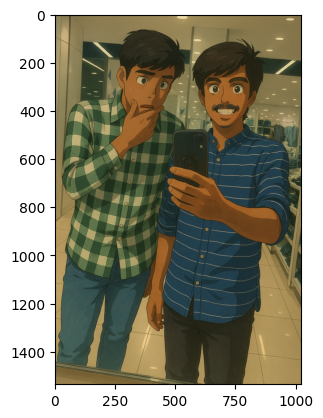

In [8]:
# Load and preprocess the image
img_path = r'ChatGPT Image Mar 29, 2025, 03_35_27 PM.png'  # Use raw string for Windows path
img = Image.open(img_path)
plt.imshow(img)

In [ ]:
img = Image.open(img_path).convert('L')  # Convert to grayscale
img = img.resize((28, 28))  # Resize to match model input
image_array = np.array(img).astype('float32') / 255.0
image_array = np.expand_dims(image_array, axis=(0, -1))
# Dummy label (since we are not training)
label = 0

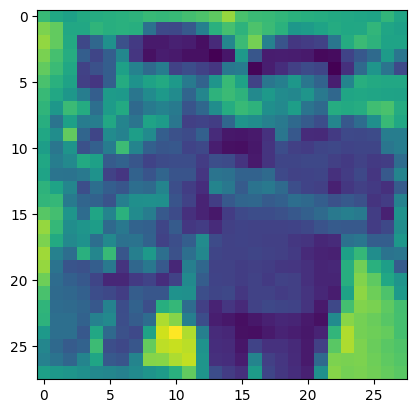

In [5]:
plt.imshow(img)

In [9]:
# Build the model using Functional API (required for tf-keras-vis)
inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

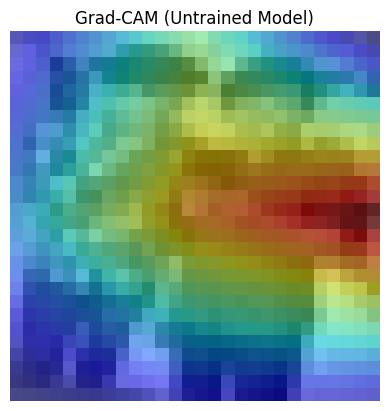

In [7]:
# Grad-CAM setup
gradcam = Gradcam(model, model_modifier=ReplaceToLinear())
score = CategoricalScore([label])
cam = gradcam(score, image_array)  # Compute heatmap
heatmap = cam[0]

# Plot the Grad-CAM result
plt.imshow(image_array[0].squeeze(), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title("Grad-CAM (Untrained Model)")
plt.axis('off')
plt.show()

LRP

In [11]:
# Imports
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [12]:
# === 1. Load and preprocess the image ===
img_path = r"M:\Images\WhatsApp Image 2025-02-18 at 13.24.36_5e6cf0e9.jpg"  # Your local path
img = Image.open(img_path).convert('L')  # Grayscale
img = img.resize((28, 28))
img_array = np.array(img).astype('float32') / 255.0
img_array = np.expand_dims(img_array, axis=-1)  # shape: (28, 28, 1)
img_batch = np.expand_dims(img_array, axis=0)   # shape: (1, 28, 28, 1)

In [13]:
# === 2. Build a simple CNN model (untrained) ===
inputs = Input(shape=(28, 28, 1))
x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

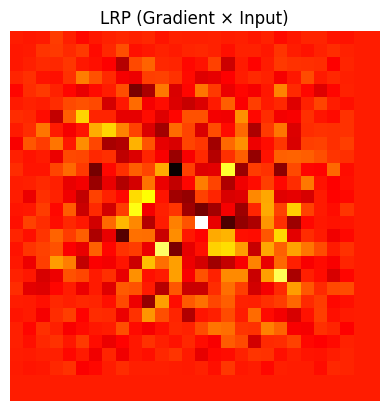

In [15]:
# === 3. LRP using Gradient × Input ===
img_tensor = tf.convert_to_tensor(img_batch)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    preds = model(img_tensor)
    class_idx = tf.argmax(preds[0])
    loss = preds[0, class_idx]

# Compute gradients
grads = tape.gradient(loss, img_tensor)[0].numpy()  # shape: (28, 28, 1)
relevance = grads * img_array  # Element-wise multiplication

# === 4. Plot the relevance heatmap ===
plt.imshow(relevance, cmap='hot')
plt.title("LRP (Gradient × Input)")
plt.axis('off')
plt.show()

Surrogate Model

In [26]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [27]:
df=pd.read_csv('diabetes (3).csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [28]:
rf_model=RandomForestClassifier()
X=df.drop('Outcome',axis=1)
y=df['Outcome']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
rf_model.fit(X_train,y_train)
y_pred=rf_model.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.7337662337662337


In [29]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_test,y_pred)

DecisionTreeClassifier()

[Text(0.5, 0.9285714285714286, 'Glucose <= 125.5\ngini = 0.455\nsamples = 154\nvalue = [100, 54]\nclass = Diabetes'),
 Text(0.2777777777777778, 0.7857142857142857, 'Age <= 41.5\ngini = 0.173\nsamples = 94\nvalue = [85, 9]\nclass = Diabetes'),
 Text(0.3888888888888889, 0.8571428571428572, 'True  '),
 Text(0.16666666666666666, 0.6428571428571429, 'BloodPressure <= 24.0\ngini = 0.052\nsamples = 75\nvalue = [73, 2]\nclass = Diabetes'),
 Text(0.1111111111111111, 0.5, 'BMI <= 15.0\ngini = 0.444\nsamples = 6\nvalue = [4, 2]\nclass = Diabetes'),
 Text(0.05555555555555555, 0.35714285714285715, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = Diabetes'),
 Text(0.16666666666666666, 0.35714285714285715, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = No Diabetes'),
 Text(0.2222222222222222, 0.5, 'gini = 0.0\nsamples = 69\nvalue = [69, 0]\nclass = Diabetes'),
 Text(0.3888888888888889, 0.6428571428571429, 'BMI <= 30.0\ngini = 0.465\nsamples = 19\nvalue = [12, 7]\nclass = Diabetes'),
 Text(0.33333

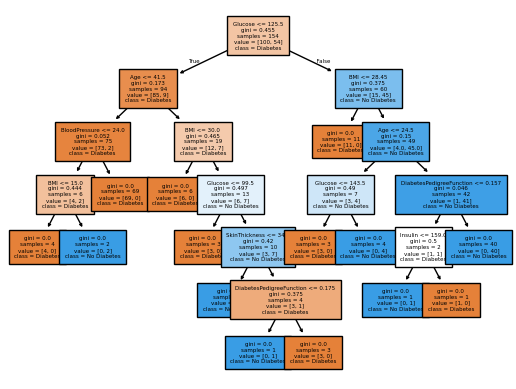

In [23]:
plot_tree(dt_model,
feature_names=X.columns,
class_names=['Diabetes','No Diabetes'],
filled=True,
fontsize=4
)


Sensitivity Analysis & Feature Importance

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [33]:
import pandas as pd
df = pd.read_csv("diabetes (3).csv")
df

# Use only 2 classes for simplicity
# Split data
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
model = RandomForestClassifier().fit(X_train, y_train)


<BarContainer object of 8 artists>

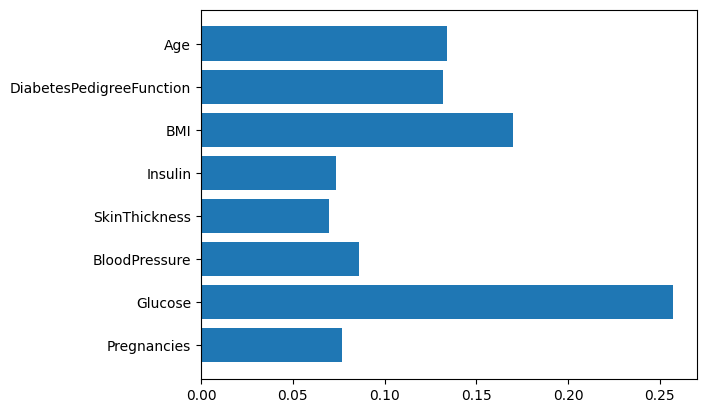

In [34]:
feat_imp=model.feature_importances_
feat=X.columns
plt.barh(feat,feat_imp)


Baseline Accuracy: 0.7760


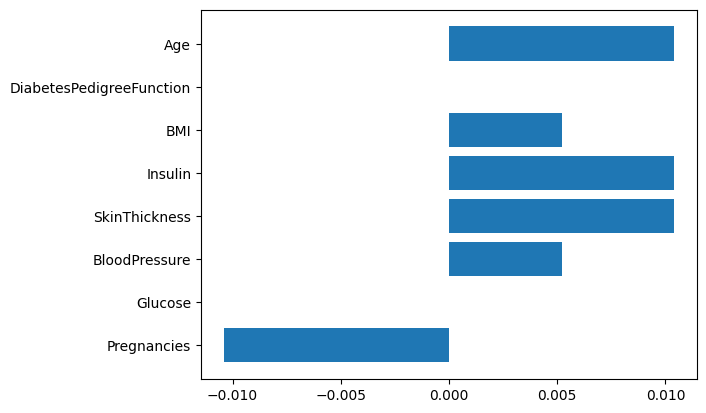

In [42]:
from sklearn.metrics import accuracy_score
# Baseline accuracy
baseline_pred = model.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_pred)
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# Sensitivity Analysis: Perturb one feature at a time
sensitivity = {}

for col in X.columns:
    X_test_perturbed = X_test.copy()
    X_test_perturbed[col] += X_test_perturbed[col].std()  # Add one std deviation

    perturbed_pred = model.predict(X_test_perturbed)
    perturbed_acc = accuracy_score(y_test, perturbed_pred)
    
    sensitivity[col] = baseline_acc - perturbed_acc

# Convert to DataFrame
sensitivity_df = pd.DataFrame(list(sensitivity.items()), columns=['Feature', 'Accuracy Drop'])

# Plot
plt.figure()
plt.barh(sensitivity_df['Feature'], sensitivity_df['Accuracy Drop'])
plt.show()